In [14]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики

from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

## Логистическая регрессия

In [17]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.zip')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


In [18]:
diabetes_data.shape

(757, 8)

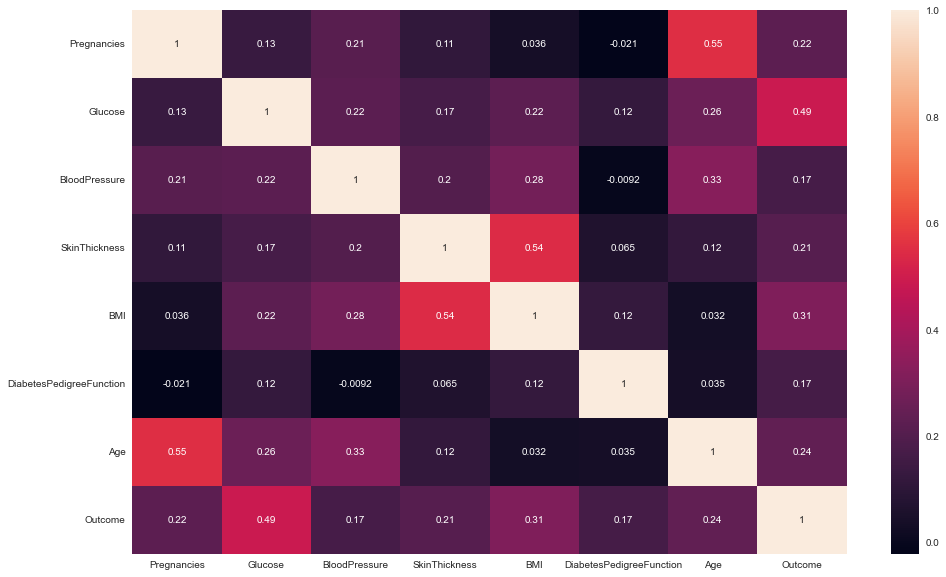

In [19]:
fig, ax = plt.subplots(figsize = (16, 10))
sns.heatmap(diabetes_data.corr(), annot=True);

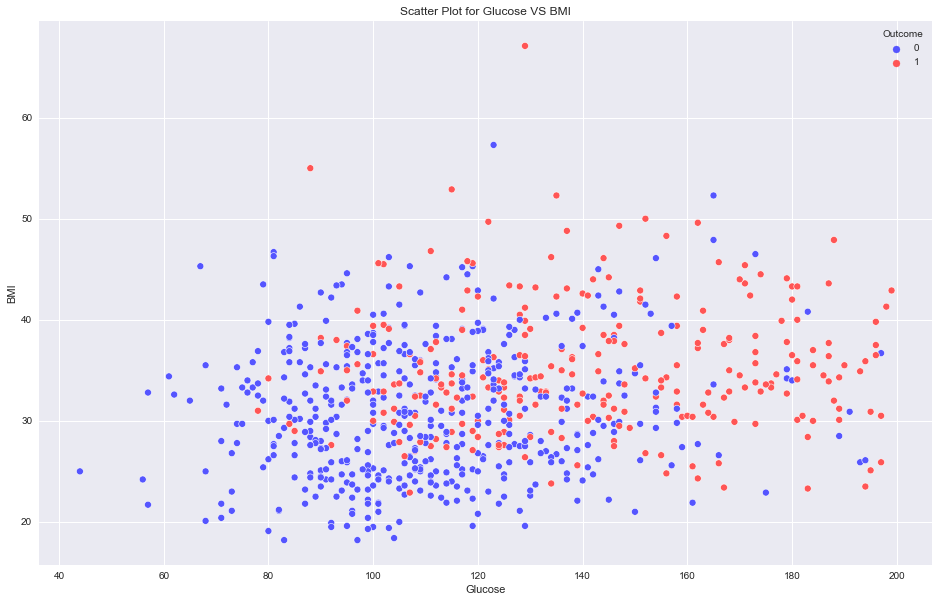

In [20]:
fig, ax = plt.subplots(figsize = (16, 10)) # фигура + координатная плоскость
# Строим диаграмму рассеяния
sns.scatterplot(
    data=diabetes_data, # датасет
    x='Glucose', # ось абсцисс
    y='BMI', # ось ординат
    hue='Outcome', # группировка
    palette='seismic', # палитра
    ax=ax, # координатная плоскость
);

# Задаем название графику
ax.set_title('Scatter Plot for Glucose VS BMI');

In [21]:
# Создаем матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

In [22]:
# Создаем объект класса логистическая регрессия
log_reg_2d = linear_model.LogisticRegression(random_state=42)

# Обучаем модель, минизируя logloss
log_reg_2d.fit(X, y)

# Выводим результирующие коэффициенты
print(f'w0: {log_reg_2d.intercept_}') # свободный член w0
print(f'w1, w2: {log_reg_2d.coef_}') # остальные параметры модели w1, w2, ..., wm

w0: [-8.24898965]
w1, w2: [[0.03779275 0.0875742 ]]


In [23]:
# Значения концентации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]

# Делаем предсказание вероятностей:
y_new_proba_predict = log_reg_2d.predict_proba(x_new)
print(f'Predicted probabilities: {np.round(y_new_proba_predict, 2)}')

Predicted probabilities: [[0.05 0.95]]


In [24]:
# Значения концентации глюкозы и индекса массы тела для пациента
x_new = [[180, 51]]

# Делаем предсказание класса:
y_new_predict = log_reg_2d.predict(x_new)
print(f'Predicted class: {y_new_predict}')

Predicted class: [1]


In [25]:
# Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    # Генерируем координатную сетку из всех возможных значений для признаков
    # Glucose изменяется от x1_min = 44 до x2_max = 199, 
    # BMI - от x2_min = 18.2 до x2_max = 67.1
    # Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    
    # Вытягиваем каждый из массивов в вектор-столбец - reshape(-1, 1)
    # Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    
    # Предсказывает вероятность для всех точек на координатной сетке
    # Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    
    # Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    
    # Создаем фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (16, 10))
    
    # Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    
    # Рисуем разделяющую плоскость - линия, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    
    # Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    
    # Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    
    # Даем графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    
    # Смещаем легену в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

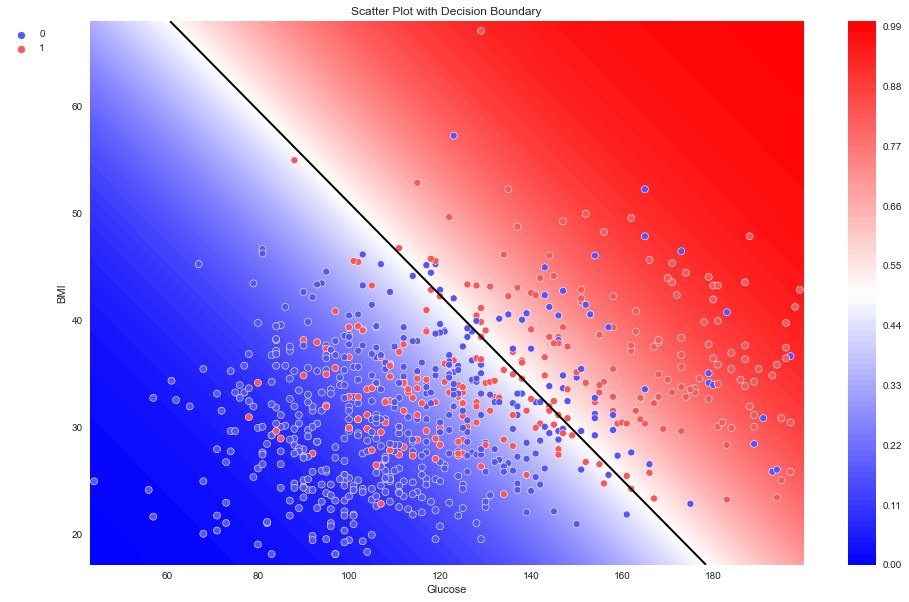

In [26]:
plot_probabilities_2d(X, y, log_reg_2d)

In [27]:
# Создаем матрицу всех признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

In [28]:
# Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Обучаем модель, минизируя logloss
log_reg_full.fit(X, y)

# Делаем предсказание класса
y_pred = log_reg_full.predict(X)

# Создадим временную таблицу X
X_temp = X.copy()

# Добавим в эту таблицу результат предсказания
X_temp['Prediction'] = y_pred
X_temp.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Prediction
752,5,139.0,64.0,35.0,28.6,0.411,26,0
753,1,96.0,122.0,29.0,22.4,0.207,27,0
754,10,101.0,86.0,37.0,45.6,1.136,38,1
755,0,141.0,72.0,29.0,42.4,0.205,29,1
756,0,125.0,96.0,29.0,22.5,0.262,21,0


In [29]:
# Делаем предсказание моделью, обученной на двух факторах 
y_pred1 = log_reg_2d.predict(diabetes_data[['Glucose', 'BMI']])

# Делаем предсказание моделью, обученной на всех факторах 
y_pred2 = log_reg_full.predict(diabetes_data.drop('Outcome', axis=1))

## Метрики классификации

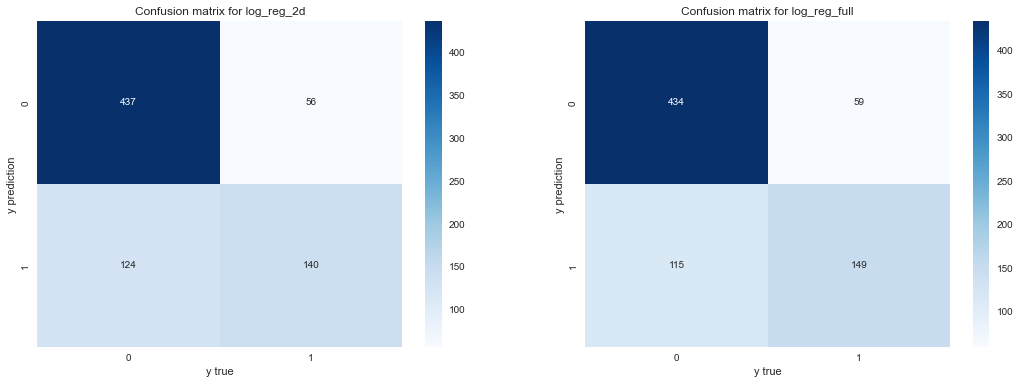

In [30]:
# Строим матрицы ошибок для каждой из моделей
confusion_matrix1 = metrics.confusion_matrix(y, y_pred1)
confusion_matrix2 = metrics.confusion_matrix(y, y_pred2)

# Визуализируем матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(18, 6)) # фигура + 2 координатные плоскости

# Строим тепловую карту для первой матрицы ошибок
sns.heatmap(confusion_matrix1, annot=True, fmt='', ax=axes[0], cmap='Blues')

# Добавляем название графику и подписи осей абсцисс и ординат
axes[0].set_title('Confusion matrix for log_reg_2d')
axes[0].set_xlabel('y true')
axes[0].set_ylabel('y prediction')

# Строим тепловую карту для второй матрицы ошибок
sns.heatmap(confusion_matrix2, annot=True, fmt='', ax=axes[1], cmap='Blues')

# Добавляем название графику и подписи осей абсцисс и ординат
axes[1].set_title('Confusion matrix for log_reg_full')
axes[1].set_xlabel('y true')
axes[1].set_ylabel('y prediction');

In [31]:
# Модель log_reg_2d:
# Рассчитываем accuracy
print(f'Accuracy: {metrics.accuracy_score(y, y_pred1):.2f}')

# Рассчитываем precision
print(f'Precision: {metrics.precision_score(y, y_pred1):.2f}')

# Рассчитываем recall
print(f'Recall: {metrics.recall_score(y, y_pred1):.2f}')

# Рассчитываем F1-меру
print(f'F1 score: {metrics.f1_score(y, y_pred1):.2f}')

Accuracy: 0.76
Precision: 0.71
Recall: 0.53
F1 score: 0.61


In [32]:
#Модель log_reg_full:
#Рассчитываем accuracy
print(f'Accuracy: {metrics.accuracy_score(y, y_pred2):.2f}')

# Рассчитываем precision
print(f'Precision: {metrics.precision_score(y, y_pred2):.2f}')

# Рассчитываем recall
print(f'Recall: {metrics.recall_score(y, y_pred2):.2f}')

# Рассчитываем F1-меру
print(f'F1 score: {metrics.f1_score(y, y_pred2):.2f}')

Accuracy: 0.77
Precision: 0.72
Recall: 0.56
F1 score: 0.63


In [33]:
print(metrics.classification_report(y, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       493
           1       0.72      0.56      0.63       264

    accuracy                           0.77       757
   macro avg       0.75      0.72      0.73       757
weighted avg       0.76      0.77      0.76       757



Сделаем предсказание вероятности наличия диабета моделью log_reg_full для каждого пациента из нашей выборки. 

Затем создадим несколько различных порогов вероятности в диапазоне от 0.1 до 1 с шагом 0.05. 

В цикле будем определять класс пациента при различных порогах вероятности. В конце рассчитаем метрики.

In [34]:
# Считаем вероятности наличия диабета для каждого из пациентов
# Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg_full.predict_proba(diabetes_data.drop('Outcome', axis=1))[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y, y_pred))
    precision_scores.append(metrics.precision_score(y, y_pred))
    f1_scores.append(metrics.f1_score(y, y_pred))

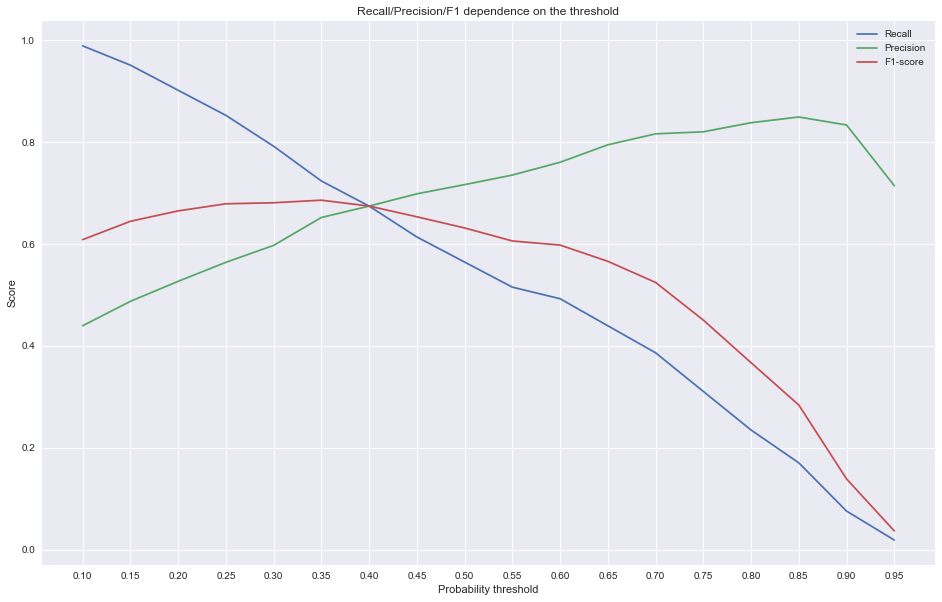

In [35]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(16, 10)) # фигура + координатная плоскость
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')

# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')

# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)

# Отображаем легенду
ax.legend();

С увеличением вероятностного порога повышается precision и падает recall. 

Очевидно, что с увеличением порога вероятности мы начинаем классифицировать как диабетиков только тех пациентов, 

в диагнозе которых мы хорошо уверены, то есть мы повышаем точность (precision), но при этом мы отсекаем пациентов, 

которые больны, но модель выдаёт низкую вероятность болезни, то есть мы уменьшаем охват (recall).

При этом значение -меры сначала немного повышается, а затем неуклонно падает.

Интересной является точка threshold=0.4, где происходит пересечение всех трёх графиков. Это точка равенства precision и recall и, как следует из формулы, равенства -меры.

Однако максимум -меры достигается в другой точке — threshold=0.35. При этом значения recall и precision в этой точке различны: recall выше, а вот precision ниже.

Перед нами стоит выбор, что для нас все таки важнее: precision, recall или их равенство. Давайте сделаем выбор в пользу равенства precision и recall, оно достигается при threshold=0.4.

In [36]:
# Задаем оптимальный порог вероятностей
threshold_opt = 0.35

# Пациентов, для которых вероятность наличия диабета > 0.4 относим к классу 1
# В противном случае - к классу 0
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Считаем метрики
print(metrics.classification_report(y, y_pred_opt))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       493
           1       0.65      0.72      0.69       264

    accuracy                           0.77       757
   macro avg       0.75      0.76      0.75       757
weighted avg       0.78      0.77      0.77       757



Итак, мы смогли найти баланс между precision и recall, подобрав оптимальный порог вероятности.

Стоит отметить, что в DS-сообществе распространена практика подбора оптимального порога, 

так как он зависит от конкретных задач и значение 0.5 далеко не всегда является истинным.

## Задание 3.6, 3.7, 3.8
У вас есть истинные ответы y_true = [0, 0, 1, 1, 1, 1, 0, 1] 

и предсказанные ответы y_pred = [0, 1, 0, 0, 1, 1, 0, 1].

Вычислите значение метрики precision.

Ответ округлите до сотых.

In [39]:
y_true = [0, 0, 1, 1, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1]

TP     = [0, 0, 0, 0, 1, 1, 0, 1]
FP     = [0, 1, 0, 0, 0, 0, 0, 0]
FN     = [0, 0, 1, 1, 0, 0, 0, 0]
TN     = [1, 0, 0, 0, 0, 0, 1, 0]

precision = TP / (TP + FP)

Сравниваю поэлементно истинные ответы и предсказания и разношу их по соответствющим категориям

In [41]:
precision = sum(TP) / (sum(TP) + sum(FP))
precision

0.75

In [42]:
metrics.precision_score(y_true, y_pred)

0.75

In [43]:
metrics.recall_score(y_true, y_pred)

0.6

In [46]:
round(metrics.f1_score(y_true, y_pred), 2)

0.67

## Мультиклассовая классификация

Описание данных:

species — класс пингвина ('Adelie', 'Chinstrap', 'Gentoo'), целевой признак;

island — остров, на котором живёт пингвин ('Torgersen', 'Biscoe', 'Dream');

bill_length_mm — длина клюва в миллиметрах;

bill_depth_mm — толщина клюва в миллиметрах;

flipper_length_mm — длина крыльев;

body_mass_g — масса;

sex — пол ('Male', 'Female').

Наша цель — предсказать класс пингвина.

In [54]:
penguins_data = sns.load_dataset('penguins')
penguins_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [55]:
penguins_data.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [56]:
penguins_data = penguins_data.dropna()

In [57]:
X = penguins_data.drop('species', axis=1)
y = penguins_data['species']
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [58]:
X_dummies = pd.get_dummies(X)
X_dummies.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,39.1,18.7,181.0,3750.0,0,0,1,0,1
1,39.5,17.4,186.0,3800.0,0,0,1,1,0
2,40.3,18.0,195.0,3250.0,0,0,1,1,0
4,36.7,19.3,193.0,3450.0,0,0,1,1,0
5,39.3,20.6,190.0,3650.0,0,0,1,0,1


In [59]:
# Создаем объект класса логистическая регрессия 
log_reg = linear_model.LogisticRegression(
    multi_class='multinomial', # мультиклассовая классификация
    max_iter=1000, # количество итераций, выделенных на сходимость
    random_state=42 # генерация случайных чисел
)

# Обучаем модель 
log_reg.fit(X_dummies, y)

# Делаем предсказание вероятностей
y_pred_proba = np.round(log_reg.predict_proba(X_dummies), 2)

# Делаем предсказание класса
y_pred = log_reg.predict(X_dummies)

In [60]:
# Создаем DataFrame из вероятностей
y_pred_proba_df = pd.DataFrame(
    y_pred_proba, 
    columns=['Adelie', 'Chinstrap', 'Gentoo']
)

# Создаем DataFrame из предсказанных классов
y_pred_df = pd.DataFrame(
    y_pred, 
    columns=['Predicted Class']
)
# Объединяем таблицы по вертикальной оси
y_df = pd.concat([y_pred_proba_df, y_pred_df], axis=1)

# Выбираем 5 случайных строк
y_df.sample(5, random_state=2)

,Adelie,Chinstrap,Gentoo,Predicted Class
277,0.00,0.00,1.0,Gentoo
223,0.00,0.00,1.0,Gentoo
7,0.77,0.23,0.0,Adelie
160,0.00,1.00,0.0,Chinstrap
65,1.00,0.00,0.0,Adelie


In [61]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00       146
   Chinstrap       1.00      1.00      1.00        68
      Gentoo       1.00      1.00      1.00       119

    accuracy                           1.00       333
   macro avg       1.00      1.00      1.00       333
weighted avg       1.00      1.00      1.00       333

